In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import os
import pydicom
import cv2

## Explaining some confusing aspects of the data
Every image in train_image data is assigned to one study in train_study data (StudyInstanceUID column). But one study can contain multiple images (more info in the **STUDY DATA** section).  

Columns 'boxes' and 'label' in train_image are somewhat redundant:
* boxes contains location and size of the boxes
* label contains location (xmin, ymin, xmax, ymax) of the boxes and confidence (which for the training data is always 1)

So we don't need 'boxes' column, we can just use the info from 'label' column.

### The 'label' column in train_image data
label column has a structure:  
a) for image with no boxes: `none 1 0 0 1 1`  
b) for image with boxes: `opacity 1 <xmin> <ymin> <xmax> <ymax>`
* if there is more than one box, there are multiple labels like this in a row, for example:  
`opacity 1 789.29 582.43 1815.94 2499.73 opacity 1 2245.91 591.21 3340.57 2352.75`
  

### How should the submission file look like?
For images it is consistent with the label column!<br/>
a) for image with no boxes: `id_image,none 1 0 0 1 1`  
b) for image with boxes: `id_image,opacity <confidence> <xmin> <ymin> <xmax> <ymax>`  
And for studies: `id_study,<class> <confidence> 0 0 1 1`

Example from the Kaggle Evaluation tab:
```
Id,PredictionString
2b95d54e4be65_study,negative 1 0 0 1 1
2b95d54e4be66_study,typical 1 0 0 1 1
2b95d54e4be67_study,indeterminate 1 0 0 1 1 atypical 1 0 0 1 1
2b95d54e4be68_image,none 1 0 0 1 1
2b95d54e4be69_image,opacity 0.5 100 100 200 200 opacity 0.7 10 10 20 20
```

Also, if I understand correctly, every study in train and test data is assigned to exactly one class (the classes are mutually exclusive) and it's best if you predict that class. But if you are not sure about your prediction, you can also try multilabel classification, for example: `2b95d54e4be65_study,negative 0.7 0 0 1 1 indeterminate 0.6 0 0 1 1`.

## Let's look at the data!

In [2]:
train_image = pd.read_csv('../input/siim-covid19-detection/train_image_level.csv')
train_study = pd.read_csv('../input/siim-covid19-detection/train_study_level.csv')
print('shape of train_image:', train_image.shape)
train_image.head()

shape of train_image: (6334, 4)


,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


In [3]:
print('shape of train_study:', train_study.shape)
train_study.head()

shape of train_study: (6054, 5)


,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


In [4]:
TRAIN_DIR = '../input/siim-covid19-detection/train'
TEST_DIR = '../input/siim-covid19-detection/test'

# IMAGE DATA

This is how you can get to an image:

In [5]:
# take first example and get path to it
from os import walk, listdir
image_dir = train_image['StudyInstanceUID'][0]
path_to_img = TRAIN_DIR + '/' + image_dir 
path_to_img = path_to_img +'/' + listdir(path_to_img)[0] 
path_to_img = path_to_img + '/' + next(walk(path_to_img))[2][0]

The image files are in DICOM (.dcm) format. This format is often used in the medical images since it contains information about the patient (to avoid mismatching the patients' data). DICOM format can be handled using pydicom package (see more: https://pydicom.github.io/pydicom/stable/index.html )

In [6]:
data = pydicom.dcmread(path_to_img)
# get the pixel information into a numpy array
img = data.pixel_array
print('The image has {} x {} voxels'.format(img.shape[0],
                                            img.shape[1]))

The image has 3488 x 4256 voxels


In [7]:
print(img, img.shape)

[[2809 2799 2836 ...   63 1791    0]
 [2815 2804 2861 ...   63 2540    0]
 [2867 2872 2918 ...   63 2545    0]
 ...
 [  55   55   55 ...   43   43    0]
 [  53   53   54 ...   45   43    0]
 [   0    0    0 ...    0    0    0]] (3488, 4256)


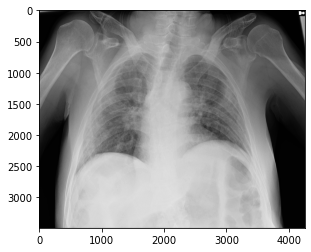

In [8]:
import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray')
plt.show()

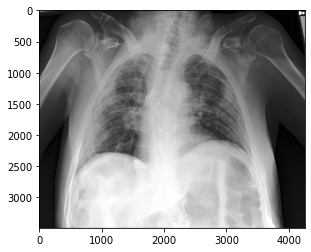

In [9]:
# this can help with increasing the contrast
from skimage import exposure
equ_img = exposure.equalize_hist(img)
plt.imshow(equ_img, cmap='gray')
plt.show()

In [10]:
equ_img

array([[6.87025360e-01, 6.84637473e-01, 6.93017912e-01, ...,
        9.07575301e-02, 3.78908742e-01, 5.21592291e-04],
       [6.88219101e-01, 6.85824141e-01, 6.99264826e-01, ...,
        9.07575301e-02, 6.21718947e-01, 5.21592291e-04],
       [7.00552000e-01, 7.01840117e-01, 7.13629463e-01, ...,
        9.07575301e-02, 6.23138489e-01, 5.21592291e-04],
       ...,
       [8.94533810e-02, 8.94533810e-02, 8.94533810e-02, ...,
        7.26451486e-02, 7.26451486e-02, 5.21592291e-04],
       [8.89965246e-02, 8.89965246e-02, 8.92869942e-02, ...,
        7.94934135e-02, 7.26451486e-02, 5.21592291e-04],
       [5.21592291e-04, 5.21592291e-04, 5.21592291e-04, ...,
        5.21592291e-04, 5.21592291e-04, 5.21592291e-04]])

### Let's see the boxes...

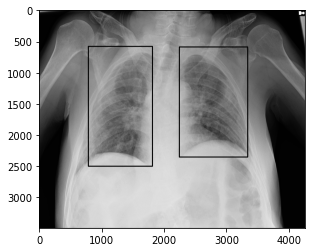

In [11]:
box1 = train_image.label[0].split()[:6]
box2 = train_image.label[0].split()[6:]
img = cv2.rectangle(img,(int(float(box1[2])), int(float(box1[3]))), 
                    (int(float(box1[4])), int(float(box1[5]))),
                    color=(0, 0, 0), thickness=15)

img = cv2.rectangle(img,(int(float(box2[2])), int(float(box2[3]))), 
                    (int(float(box2[4])), int(float(box2[5]))),
                    color=(0, 0, 0), thickness=15)
plt.imshow(img, cmap='gray')
plt.show()

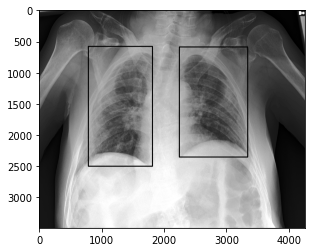

In [12]:
# now on image with equalize_hist
equ_img = cv2.rectangle(equ_img,(int(float(box1[2])), int(float(box1[3]))), 
                    (int(float(box1[4])), int(float(box1[5]))),
                    color=(0, 0, 0), thickness=15)

equ_img = cv2.rectangle(equ_img,(int(float(box2[2])), int(float(box2[3]))), 
                    (int(float(box2[4])), int(float(box2[5]))),
                    color=(0, 0, 0), thickness=15)
plt.imshow(equ_img, cmap='gray')
plt.show()

In [13]:
shape1, shape2, ratios = [], [], []
for study_id in set(train_image.StudyInstanceUID):
    path1 = TRAIN_DIR + '/' + study_id 
    for p in listdir(path1):
        path_to_img = path1 +'/' + p
        path_to_img = path_to_img + '/' + next(walk(path_to_img))[2][0]
        data = pydicom.dcmread(path_to_img)
        sh1 = data.Rows
        sh2 = data.Columns
        shape1.append(sh1)
        shape2.append(sh2)
        ratios.append(sh1/sh2)

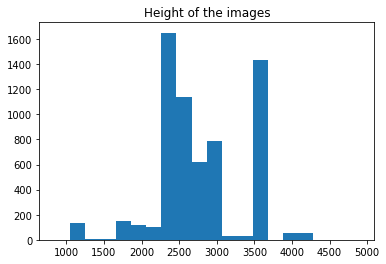

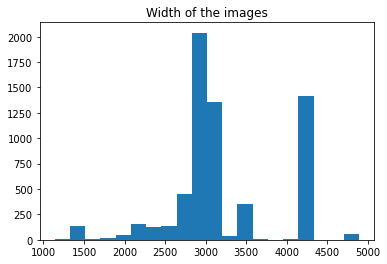

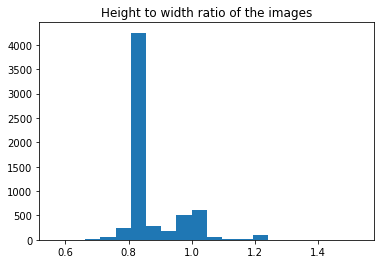

In [14]:
plt.hist(shape1, bins=20)
plt.title('Height of the images')
plt.show()
plt.hist(shape2, bins=20)
plt.title('Width of the images')
plt.show()
plt.hist(ratios, bins=20)
plt.title('Height to width ratio of the images')
plt.show()

# STUDY DATA

In [15]:
# the studies in train_study_level.csv file aren't multilabeled:
labels_sum = train_study.iloc[:,1:].sum(axis=1)
print('Min number of labels:', min(labels_sum))
print('Max number of labels:', max(labels_sum))

Min number of labels: 1
Max number of labels: 1


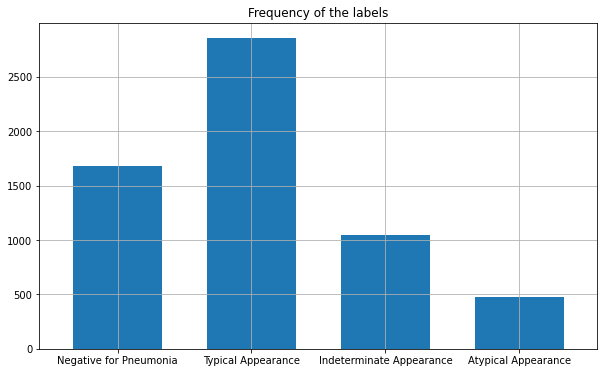

In [16]:
train_study.iloc[:,1:].sum().plot(kind='bar', figsize=(10,6), grid=True, rot=0,
                                  title='Frequency of the labels', width=2/3)
plt.show()

For most of the studies (5822 out of 6334) there is only 1 image but for some there are more (up to 9 images).  
Here is an explanation from Competition Host:
> Most of the studies only have 1 image.  
In some cases, however, there are studies with more than 1 image. In these cases, patients were imaged more than once on the same date/time (same StudyInstanceUID). In some cases, there is motion artifact, so the tech re-took the image. In other cases, different image processing is applied (the images look almost identical, but there is subtle change in contrast). In other cases, there are coverage, image penetration, or other technique issues, presumably resulting in the technologist needing to retake radiographs.  
(...) We are addressing this issue currently regarding the duplicates and test set. We'll let you know when this process is completed.

[source](https://www.kaggle.com/c/siim-covid19-detection/discussion/240250#1322940)

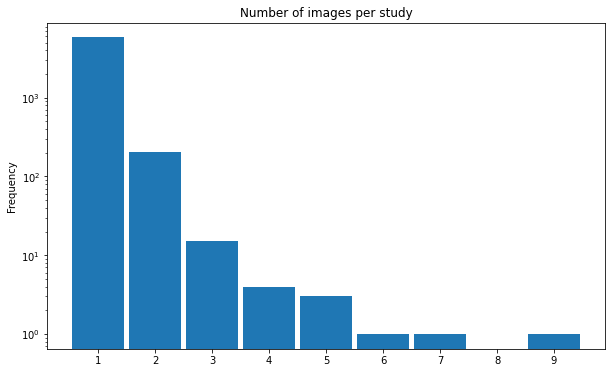

1    5822
2     207
3      15
4       4
5       3
9       1
6       1
7       1
Name: StudyInstanceUID, dtype: int64


In [17]:
train_image.StudyInstanceUID.value_counts().plot(kind='hist', logy=True, bins=np.arange(1,11)-0.5,
                                           xticks=range(1,10), title='Number of images per study',
                                           figsize=(10,6), rwidth=0.9)
plt.show()
print(train_image.StudyInstanceUID.value_counts().value_counts())

## Boxes
All of the images marked as "Negative for Pneumonia" don't have any boxes. But there are also some images from other categories with no boxes.

In [18]:
n_nan = train_image.boxes.isna().sum()
n_boxes = len(train_image.boxes) - n_nan
print(f'There are {n_boxes} images with boxes and {n_nan} images without any boxes.')

There are 4294 images with boxes and 2040 images without any boxes.


In [19]:
print('Labels of images with no boxes')
train_study[train_study.id.str.split('_').str[0].isin(set(train_image[train_image.boxes.isna()].StudyInstanceUID))].iloc[:,1:].sum()

Labels of images with no boxes


Negative for Pneumonia      1676
Typical Appearance           131
Indeterminate Appearance      42
Atypical Appearance           88
dtype: int64

In [20]:
print('Labels of images with boxes')
train_study[train_study.id.str.split('_').str[0].isin(set(train_image[~train_image.boxes.isna()].StudyInstanceUID))].iloc[:,1:].sum()

Labels of images with boxes


Negative for Pneumonia         0
Typical Appearance          2854
Indeterminate Appearance    1049
Atypical Appearance          391
dtype: int64